## **Importing libraries and datasets**

In [79]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [80]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [81]:
df_response.head()

customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1

In [82]:
df_transactions.head()

customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78

In [83]:
df_transactions.nunique()

customer_id    6889
trans_date     1401
tran_amount      96
dtype: int64

In [84]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [85]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

customer_id trans_date  tran_amount  recent
0      CS5295 2013-02-11           35   764.0
1      CS4768 2015-03-15           39     2.0
2      CS2122 2013-02-26           52   749.0
3      CS1217 2011-11-16           99  1217.0
4      CS1850 2013-11-20           78   482.0

In [86]:
#active moth
df_transactions['YM'] = df_transactions['trans_date'].dt.strftime('%Y/%m')
atm_df = df_transactions.groupby(['customer_id']).agg(active_mth=('YM', 'nunique'))
atm_df

active_mth
customer_id            
CS1112               15
CS1113               18
CS1114               15
CS1115               19
CS1116               13
...                 ...
CS8996               10
CS8997               13
CS8998               13
CS8999               12
CS9000               12

[6889 rows x 1 columns]

In [87]:
#meantime

mtbp_df = df_transactions[['customer_id', 'trans_date']].drop_duplicates().sort_values('trans_date')
mtbp_df['lag'] = mtbp_df[['customer_id', 'trans_date']].groupby(['customer_id'])['trans_date'].shift(1)
mtbp_df['date_diff'] = (mtbp_df['trans_date'] - mtbp_df['lag'])/np.timedelta64(1,'D')
mtbp_df = mtbp_df.groupby(['customer_id']).agg(mean_time = pd.NamedAgg(column='date_diff', aggfunc='mean')).reset_index().fillna(0)
mtbp_df

customer_id   mean_time
0         CS1112   93.500000
1         CS1113   75.222222
2         CS1114   72.722222
3         CS1115   62.047619
4         CS1116   96.250000
...          ...         ...
6884      CS8996   93.333333
6885      CS8997   85.846154
6886      CS8998  107.750000
6887      CS8999   97.545455
6888      CS9000  106.083333

[6889 rows x 2 columns]

In [88]:
#spend
spend_df = df_transactions.groupby('customer_id').agg(
    min_spend=('tran_amount', 'min'),
    max_spend=('tran_amount', 'max'),
    avg_spend=('tran_amount', 'mean'),
    std_spend=('tran_amount', 'std')
).reset_index()
spend_df

customer_id  min_spend  max_spend  avg_spend  std_spend
0         CS1112         36        105  67.466667  19.766012
1         CS1113         36         98  74.500000  21.254102
2         CS1114         37        105  75.368421  21.341692
3         CS1115         41        104  75.409091  18.151896
4         CS1116         40        105  65.923077  22.940000
...          ...        ...        ...        ...        ...
6884      CS8996         24         79  44.769231  18.749017
6885      CS8997         21         75  38.785714  14.000981
6886      CS8998         13         79  48.000000  22.319648
6887      CS8999         18         64  31.916667  15.453498
6888      CS9000         16         77  41.000000  22.304708

[6889 rows x 5 columns]

In [89]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [90]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

customer_id  recency  frequency  monetary_value
0      CS1112     62.0         15            1012
1      CS1113     36.0         20            1490
2      CS1114     33.0         19            1432
3      CS1115     12.0         22            1659
4      CS1116    204.0         13             857

In [91]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [92]:
df_clv = df_clv.reset_index()
df_clv.head()

customer_id  recency  frequency  monetary_value   AOU  ticket_size
0      CS1112     62.0         15            1012  1309    67.466667
1      CS1113     36.0         20            1490  1354    74.500000
2      CS1114     33.0         19            1432  1309    75.368421
3      CS1115     12.0         22            1659  1303    75.409091
4      CS1116    204.0         13             857  1155    65.923077

In [93]:
singleview = df_clv.merge(atm_df, how = 'left', on = 'customer_id')

In [94]:
singleview = singleview.merge(mtbp_df, how = 'left', on = 'customer_id')

In [95]:
singleview = singleview.merge(spend_df, how = 'left', on = 'customer_id')

In [ ]:
singleview

index customer_id  recency  ...  max_spend  avg_spend  std_spend
0         0      CS1112     62.0  ...        105  67.466667  19.766012
1         1      CS1113     36.0  ...         98  74.500000  21.254102
2         2      CS1114     33.0  ...        105  75.368421  21.341692
3         3      CS1115     12.0  ...        104  75.409091  18.151896
4         4      CS1116    204.0  ...        105  65.923077  22.940000
...     ...         ...      ...  ...        ...        ...        ...
6884   6884      CS8996     98.0  ...         79  44.769231  18.749017
6885   6885      CS8997    262.0  ...         75  38.785714  14.000981
6886   6886      CS8998     85.0  ...         79  48.000000  22.319648
6887   6887      CS8999    258.0  ...         64  31.916667  15.453498
6888   6888      CS9000     17.0  ...         77  41.000000  22.304708

[6889 rows x 13 columns]

## **Calculating response rate**

In [96]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

response  customer_id
0         0         6237
1         1          647

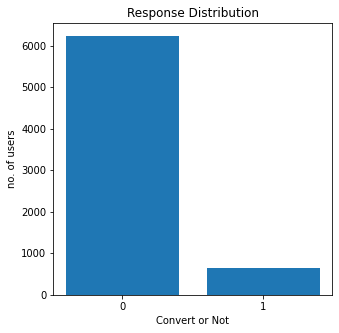

In [97]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
# ## merging two data sets - RFM

# df_modeling_rfm = pd.merge(df_response,df_rfm)
# df_modeling_rfm.head()

customer_id  response  recency  frequency  monetary_value
0      CS1112         0     62.0         15            1012
1      CS1113         0     36.0         20            1490
2      CS1114         1     33.0         19            1432
3      CS1115         1     12.0         22            1659
4      CS1116         1    204.0         13             857

In [ ]:
# ## merging two data sets - CLV

# df_modeling_clv = pd.merge(df_response,df_clv)
# df_modeling_clv.head()

customer_id  response  index  ...  monetary_value   AOU  ticket_size
0      CS1112         0      0  ...            1012  1309    67.466667
1      CS1113         0      1  ...            1490  1354    74.500000
2      CS1114         1      2  ...            1432  1309    75.368421
3      CS1115         1      3  ...            1659  1303    75.409091
4      CS1116         1      4  ...             857  1155    65.923077

[5 rows x 8 columns]

In [102]:
## merging two data sets - singleview


df_modeling_sgv = pd.merge(df_response,singleview)
df_modeling_sgv.head()

customer_id  response  recency  ...  max_spend  avg_spend  std_spend
0      CS1112         0     62.0  ...        105  67.466667  19.766012
1      CS1113         0     36.0  ...         98  74.500000  21.254102
2      CS1114         1     33.0  ...        105  75.368421  21.341692
3      CS1115         1     12.0  ...        104  75.409091  18.151896
4      CS1116         1    204.0  ...        105  65.923077  22.940000

[5 rows x 13 columns]

## **Creating train and test dataset**

In [ ]:
# ## spliting dataframe into X and y

# X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
# y_rfm = df_modeling_rfm['response']

# X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
# y_clv = df_modeling_clv['response']

In [ ]:
# ## creating train and test dataset

# X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
# X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

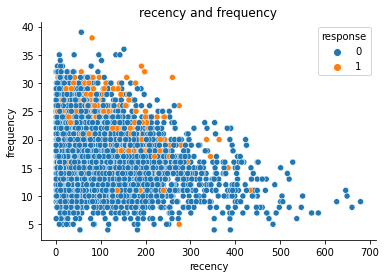

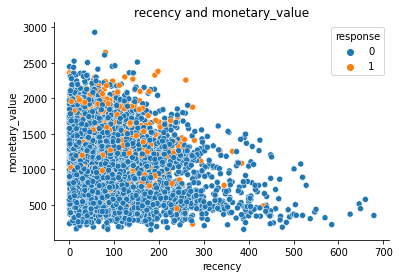

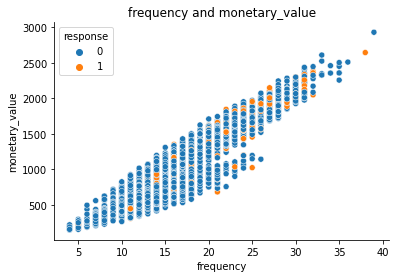

In [ ]:
# for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
#   for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
#     if i < j :
#       plt.title(col_i + ' and ' + col_j)
#       sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
#       sns.despine()
#       plt.show()

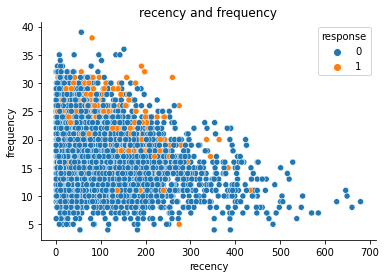

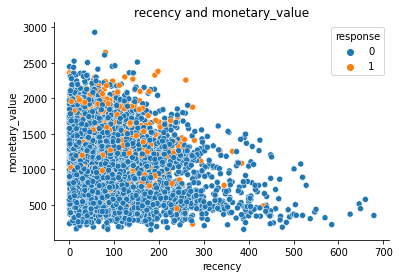

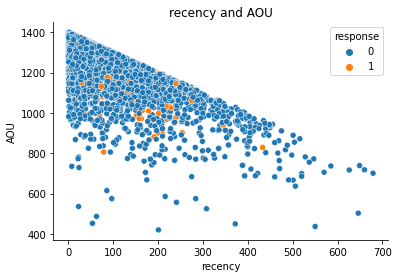

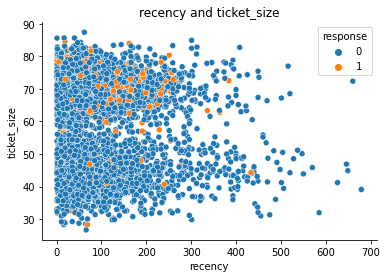

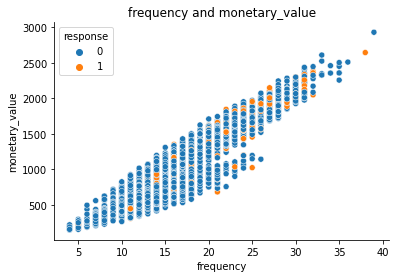

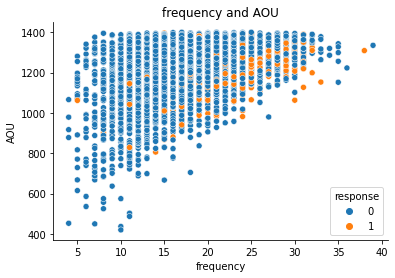

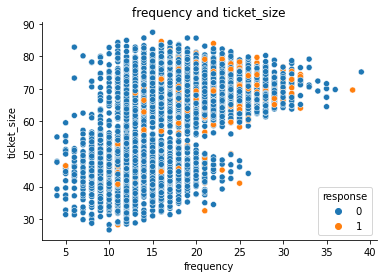

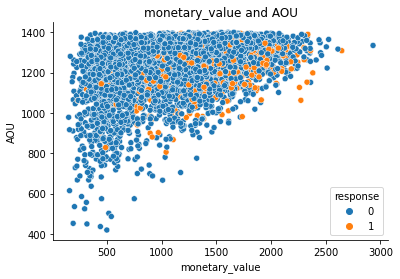

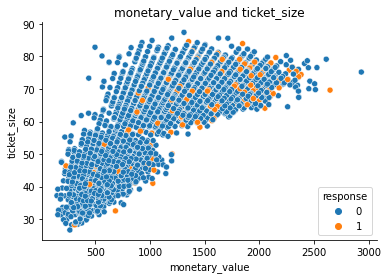

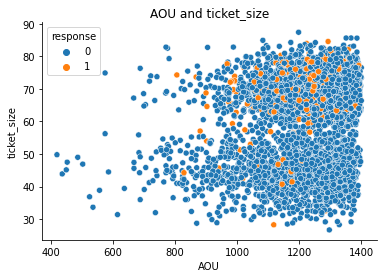

In [ ]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

In [103]:
# spliting dataframe into X and y

X_sgv = df_modeling_sgv.drop(columns=['response','customer_id'])
y_sgv = df_modeling_sgv['response']

In [107]:
df_modeling_sgv.columns

Index(['customer_id', 'response', 'recency', 'frequency', 'monetary_value',
       'AOU', 'ticket_size', 'active_mth', 'mean_time', 'min_spend',
       'max_spend', 'avg_spend', 'std_spend'],
      dtype='object')

In [104]:
## creating train and test dataset

X_train_sgv, X_test_sgv, y_train_sgv, y_test_sgv = train_test_split(X_sgv, y_sgv, test_size=0.3, random_state=0)

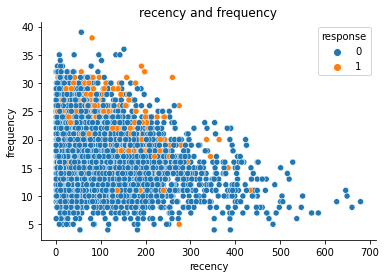

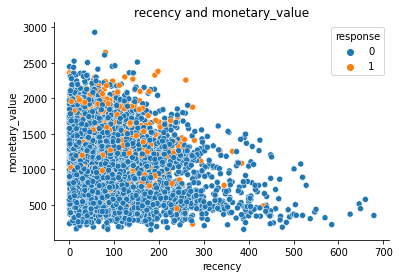

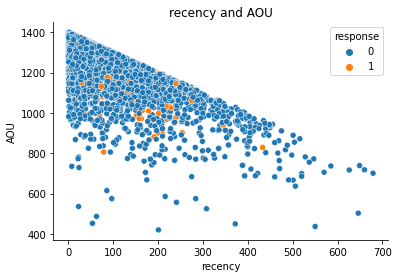

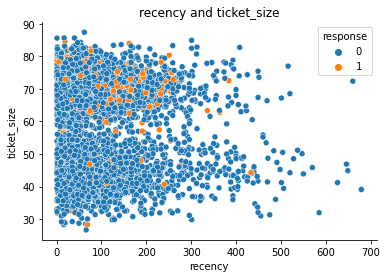

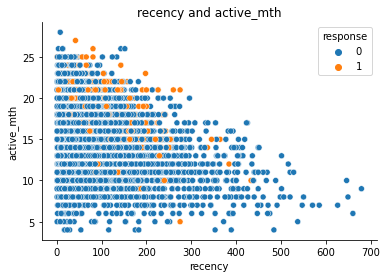

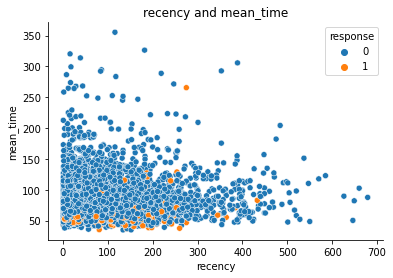

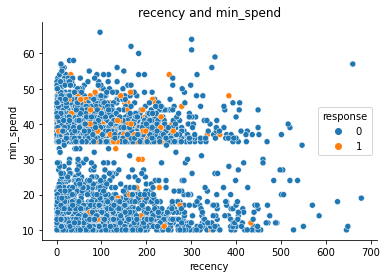

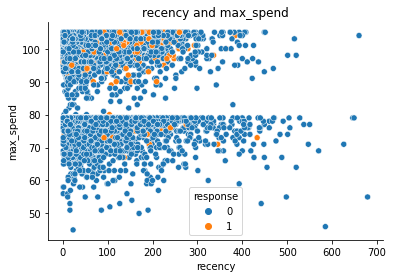

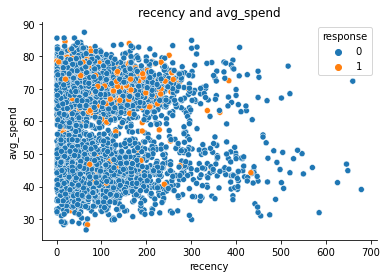

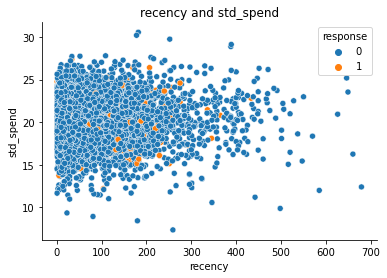

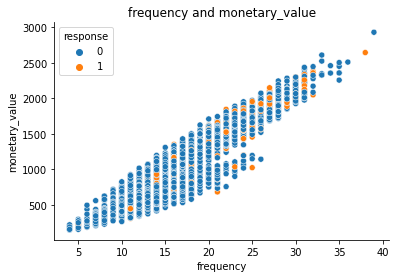

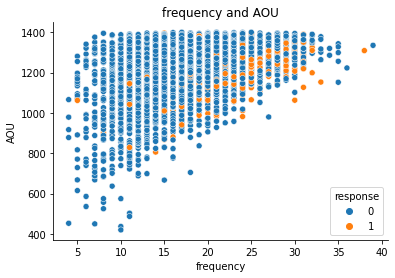

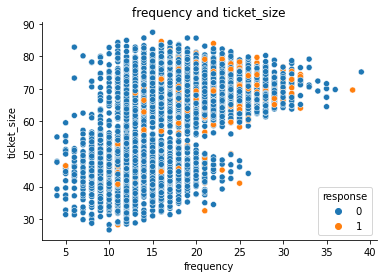

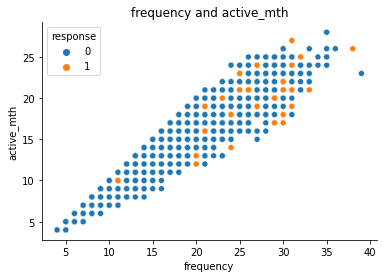

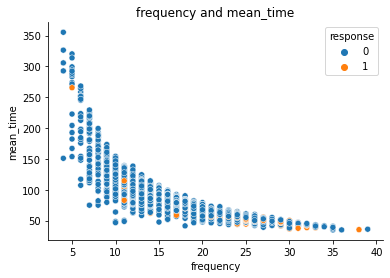

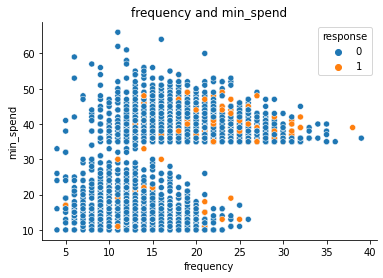

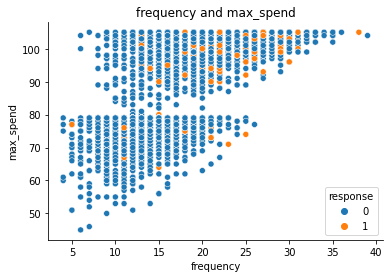

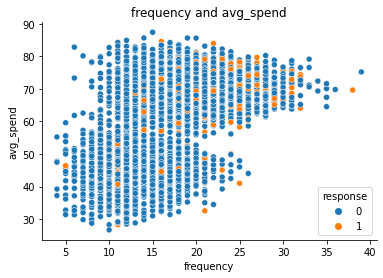

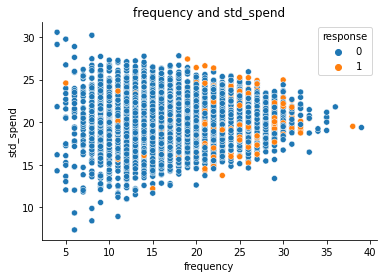

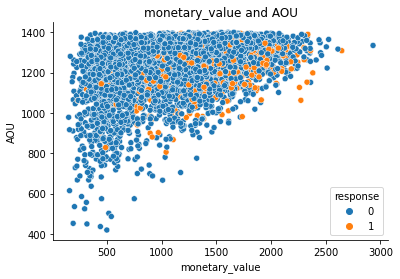

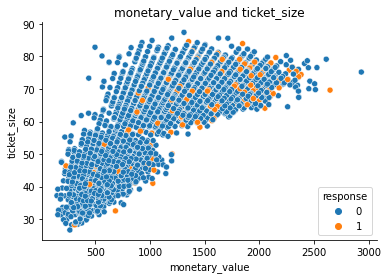

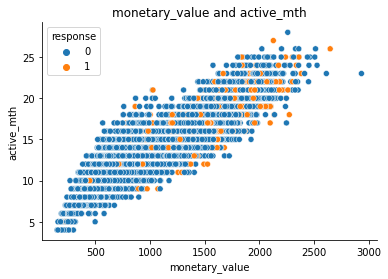

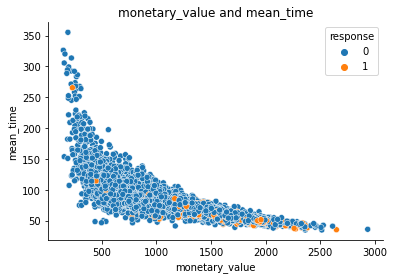

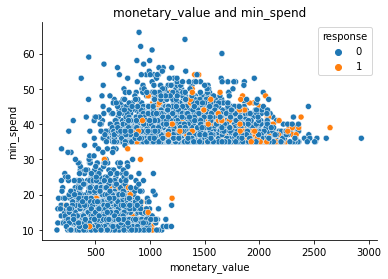

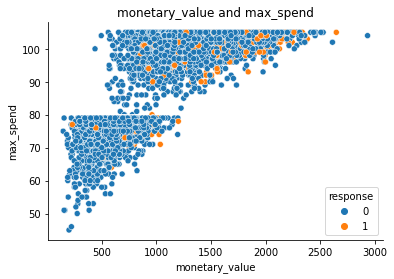

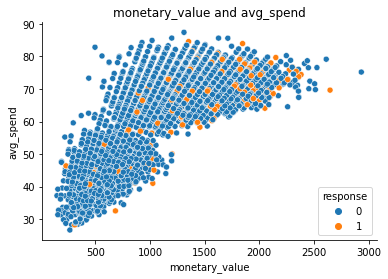

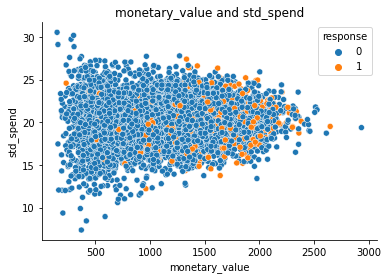

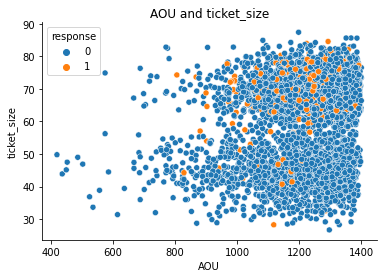

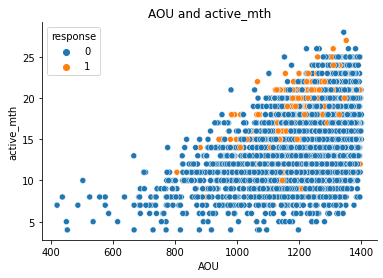

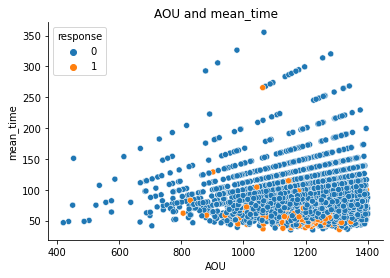

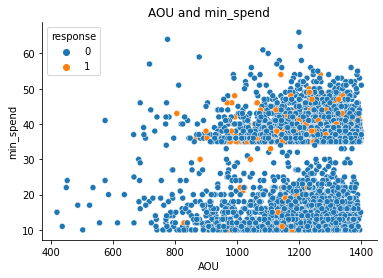

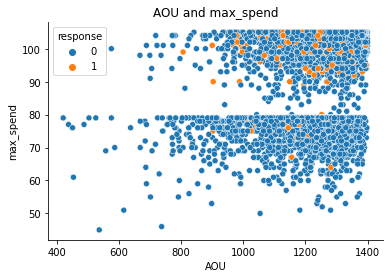

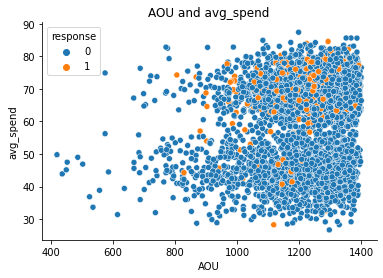

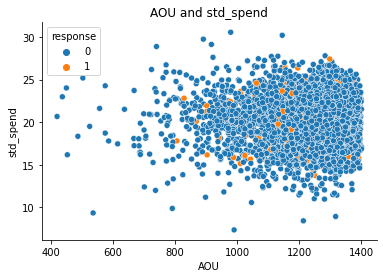

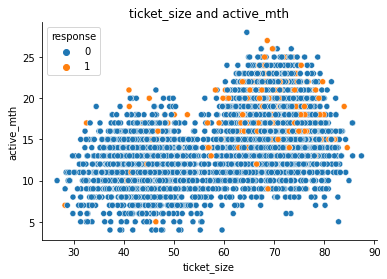

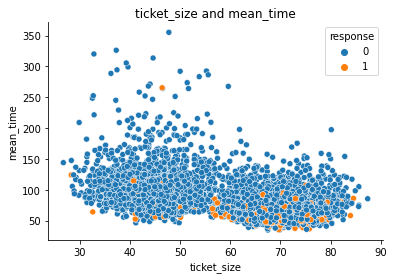

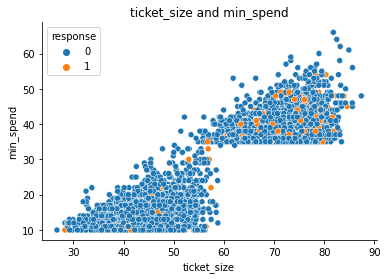

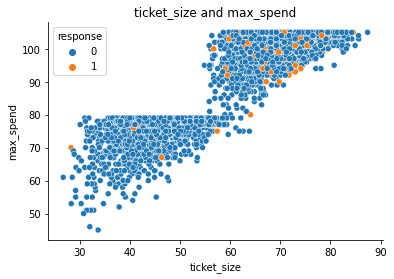

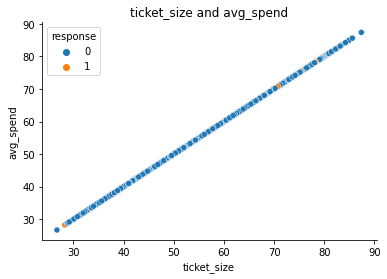

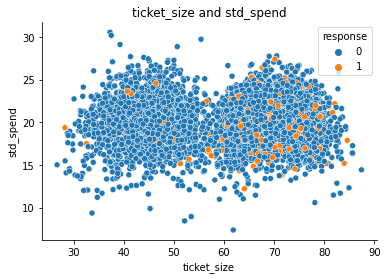

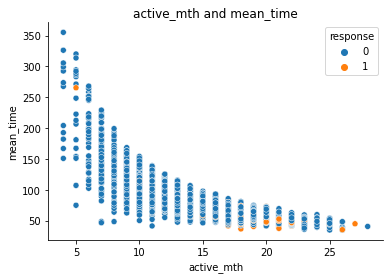

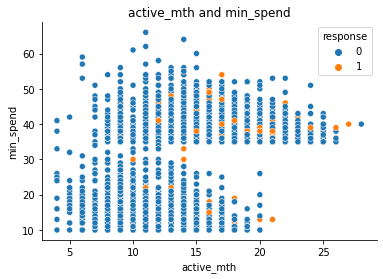

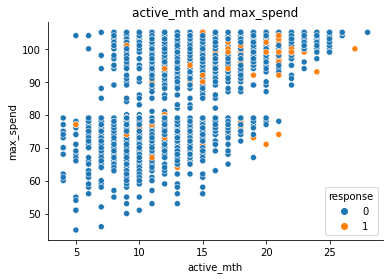

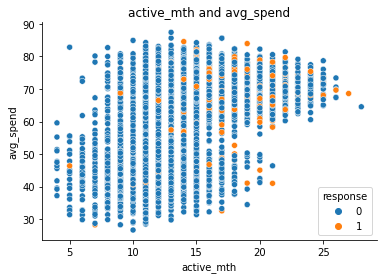

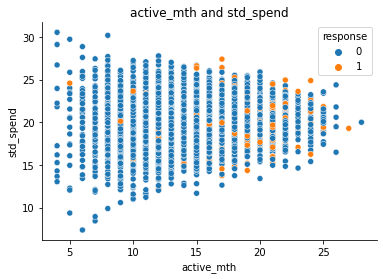

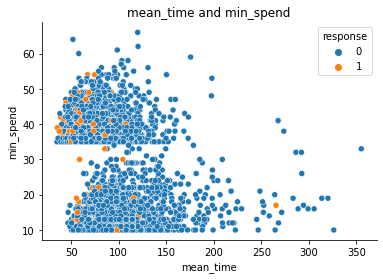

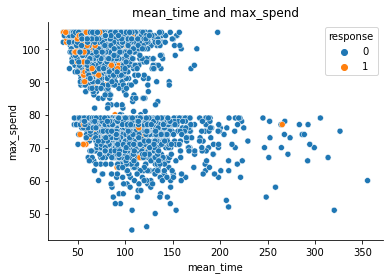

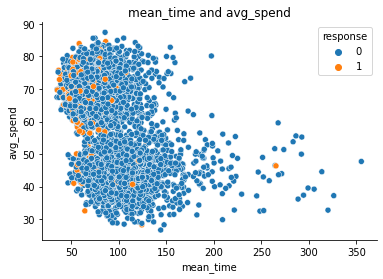

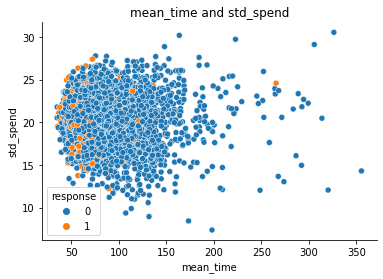

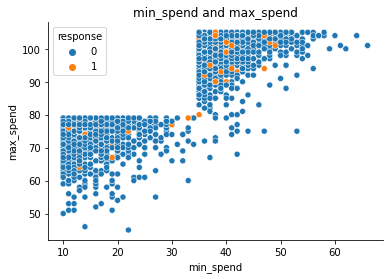

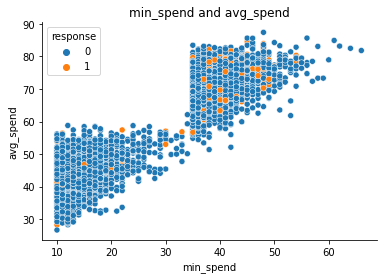

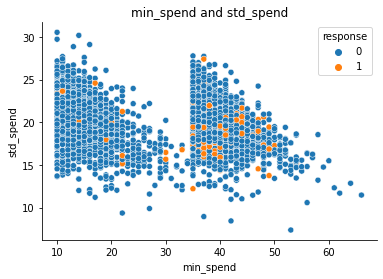

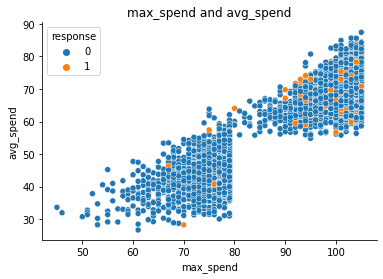

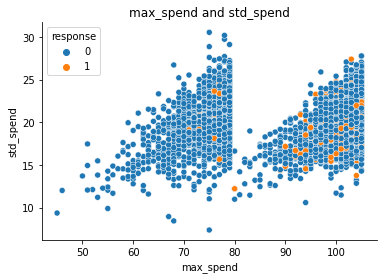

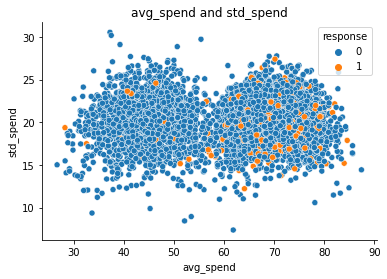

In [110]:
for i, col_i in enumerate(df_modeling_sgv[['recency', 'frequency', 'monetary_value','AOU', 'ticket_size', 'active_mth', 'mean_time', 'min_spend','max_spend', 'avg_spend', 'std_spend']].columns):
  for j, col_j in enumerate(df_modeling_sgv[['recency', 'frequency', 'monetary_value','AOU', 'ticket_size', 'active_mth', 'mean_time', 'min_spend','max_spend', 'avg_spend', 'std_spend']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_sgv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [ ]:
sm = SMOTE(random_state=0)

# sm.fit(X_train_rfm, y_train_rfm)
# X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

# sm.fit(X_train_clv, y_train_clv)
# X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [111]:
sm.fit(X_train_sgv, y_train_sgv)
X_SMOTE_sgv, y_SMOTE_sgv = sm.fit_sample(X_train_sgv, y_train_sgv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [ ]:
# print('logistic regression model - SMOTE RFM')
# logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
# predicted_y = []
# expected_y = []

# logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
# predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
# predicted_y.extend(predictions)
# expected_y.extend(y_SMOTE_rfm)
# report_train = classification_report(expected_y, predicted_y)
# print('training set')
# print(report_train) 

# predicted_y = []
# expected_y = []
# predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
# predicted_y.extend(predictions)
# expected_y.extend(y_test_clv)
# report_test = classification_report(expected_y, predicted_y)
# print('test set')
# print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066



In [ ]:
# print('logistic regression model - SMOTE CLV')
# logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
# predicted_y = []
# expected_y = []

# logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
# predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
# predicted_y.extend(predictions)
# expected_y.extend(y_SMOTE_clv)
# report_train = classification_report(expected_y, predicted_y)
# print('training set')
# print(report_train) 

# predicted_y = []
# expected_y = []
# predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
# predicted_y.extend(predictions)
# expected_y.extend(y_test_clv)
# report_test = classification_report(expected_y, predicted_y)
# print('test set')
# print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.72      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.61      0.75      1848
           1       0.18      0.74      0.29       218

    accuracy                           0.63      2066
   macro avg       0.57      0.68      0.52      2066
weighted avg       0.87      0.63      0.70      2066



In [112]:
print('logistic regression model - SMOTE SGV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_sgv = logreg.fit(X_SMOTE_sgv, y_SMOTE_sgv)
predictions = logreg_model_SMOTE_sgv.predict(X_SMOTE_sgv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_sgv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_sgv.predict(X_test_sgv)
predicted_y.extend(predictions)
expected_y.extend(y_test_sgv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE SGV
training set
              precision    recall  f1-score   support

           0       0.71      0.57      0.63      4389
           1       0.64      0.77      0.70      4389

    accuracy                           0.67      8778
   macro avg       0.68      0.67      0.67      8778
weighted avg       0.68      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1848
           1       0.18      0.80      0.30       218

    accuracy                           0.60      2066
   macro avg       0.57      0.69      0.51      2066
weighted avg       0.88      0.60      0.68      2066



## **XGBoost**

In [113]:
# print('XGBoost model - SMOTE RFM')

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
#  learning_rate =0.01,
#  n_estimators=100,
#  max_depth=2,
#  gamma=0.0,
#  colsample_bytree=0.6)

# predicted_y = []
# expected_y = []

# xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
# predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
# predicted_y.extend(predictions)
# expected_y.extend(y_SMOTE_rfm)
# report_train = classification_report(expected_y, predicted_y)
# print('training set')
# print(report_train) 

# predicted_y = []
# expected_y = []
# predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
# predicted_y.extend(predictions)
# expected_y.extend(y_test_rfm)
# report_test = classification_report(expected_y, predicted_y)
# print('test set')
# print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.713189
[2]	validation_0-auc:0.709773
[3]	validation_0-auc:0.69828
[4]	validation_0-auc:0.711449
[5]	validation_0-auc:0.713189
[6]	validation_0-auc:0.708296
Stopping. Best iteration:
[1]	validation_0-auc:0.713189

training set
              precision    recall  f1-score   support

           0       0.75      0.57      0.65      4389
           1       0.65      0.81      0.72      4389

    accuracy                           0.69      8778
   macro avg       0.70      0.69      0.69      8778
weighted avg       0.70      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      1848
           1       0.18      0.79      0.29       218

    accuracy                           0.59      2066
   macro avg       0.57      0.68      0.50      2066
weighted avg       0.88 

In [ ]:
# print('XGBoost model - SMOTE CLV')

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
#  learning_rate =0.01,
#  n_estimators=100,
#  max_depth=2,
#  gamma=0.0,
#  colsample_bytree=0.6)

# predicted_y = []
# expected_y = []

# xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
# predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
# predicted_y.extend(predictions)
# expected_y.extend(y_SMOTE_clv)
# report_train = classification_report(expected_y, predicted_y)
# print('training set')
# print(report_train) 

# predicted_y = []
# expected_y = []
# predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
# predicted_y.extend(predictions)
# expected_y.extend(y_test_clv)
# report_test = classification_report(expected_y, predicted_y)
# print('test set')
# print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.70181
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.690939
[2]	validation_0-auc:0.708448
[3]	validation_0-auc:0.703486
[4]	validation_0-auc:0.71599
[5]	validation_0-auc:0.717226
[6]	validation_0-auc:0.717262
[7]	validation_0-auc:0.715989
[8]	validation_0-auc:0.718232
[9]	validation_0-auc:0.717664
[10]	validation_0-auc:0.718503
[11]	validation_0-auc:0.719968
[12]	validation_0-auc:0.720452
[13]	validation_0-auc:0.720923
[14]	validation_0-auc:0.720265
[15]	validation_0-auc:0.720496
[16]	validation_0-auc:0.720737
[17]	validation_0-auc:0.720797
[18]	validation_0-auc:0.724681
[19]	validation_0-auc:0.724793
[20]	validation_0-auc:0.724584
[21]	validation_0-auc:0.727229
[22]	validation_0-auc:0.726492
[23]	validation_0-auc:0.726849
[24]	validation_0-auc:0.727329
[25]	validation_0-auc:0.726794
[26]	validation_0-auc:0.726535
[27]	validation_0-auc:0.726538
[28]	validation_0-auc:0.726017
[29]	validation_0-auc:0.

In [138]:
print('XGBoost model - SMOTE SGV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=3,
 gamma=0.0,
 colsample_bytree=0.4)

predicted_y = []
expected_y = []

xgb_model_SMOTE_sgv = xgb_model.fit(X_SMOTE_sgv, y_SMOTE_sgv, early_stopping_rounds=5, eval_set=[(X_test_sgv.to_numpy(), y_test_sgv)])
predictions =  xgb_model_SMOTE_sgv.predict(X_SMOTE_sgv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_sgv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_sgv.predict(X_test_sgv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_sgv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE SGV
[0]	validation_0-auc:0.719354
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.718798
[2]	validation_0-auc:0.723732
[3]	validation_0-auc:0.718561
[4]	validation_0-auc:0.718998
[5]	validation_0-auc:0.714596
[6]	validation_0-auc:0.717305
[7]	validation_0-auc:0.716984
Stopping. Best iteration:
[2]	validation_0-auc:0.723732

training set
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      4389
           1       0.71      0.79      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1848
           1       0.19      0.64      0.29       218

    accuracy                           0.68      2066
   macro avg       0.57      0.66      0.54    

In [139]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [ ]:
# ## hyper parameter tuning - grid search

# from sklearn.model_selection import KFold, GridSearchCV
# from sklearn.metrics import accuracy_score, make_scorer
# # Define our search space for grid search
# search_space = [
#   {
#     'clf__n_estimators': [100, 300],
#     'clf__learning_rate': [0.01, 0.1],
#     'clf__max_depth': range(2, 5),
#     'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
#     'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
#     'fs__k': [2],
#   }
# ]
# # Define cross validation
# kfold = KFold(n_splits=5, random_state=42)
# # AUC and F1 as score
# scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# # Define grid search
# grid = GridSearchCV(
#   pipe,
#   param_grid=search_space,
#   cv=kfold,
#   scoring=scoring,
#   refit='AUC',
#   verbose=1,
#   n_jobs=-1
# )

# # Fit grid search
# xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


In [ ]:
# predicted_y = []
# expected_y = []
# predictions = xgb_model_clv_GS.predict(X_test_clv)
# print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
# print(confusion_matrix(y_test_clv,predictions))


# predicted_y.extend(predictions)
# expected_y.extend(y_test_clv)
# report_test = classification_report(expected_y, predicted_y)
# print('test set')
# print(report_test) 

Best AUC Score: 0.6927468813713916
[[929 919]
 [ 37 181]]
test set
              precision    recall  f1-score   support

           0       0.96      0.50      0.66      1848
           1       0.16      0.83      0.27       218

    accuracy                           0.54      2066
   macro avg       0.56      0.67      0.47      2066
weighted avg       0.88      0.54      0.62      2066



In [ ]:
# print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f2301038830>}


In [140]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=7, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_sgv_GS = grid.fit(X_train_sgv, y_train_sgv)

Fitting 7 folds for each of 108 candidates, totalling 756 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed:  2.6min finished


In [141]:
predicted_y = []
expected_y = []
predictions = xgb_model_sgv_GS.predict(X_test_sgv)
print('Best AUC Score: {}'.format(xgb_model_sgv_GS.best_score_))
print(confusion_matrix(y_test_sgv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_sgv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7162208659758115
[[1084  764]
 [  51  167]]
test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1848
           1       0.18      0.77      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066



In [144]:
y_score_train = xgb_model_SMOTE_sgv.predict_proba(X_SMOTE_sgv)
auc_train = roc_auc_score(y_SMOTE_sgv, y_score_train[:,1])
y_score_test = xgb_model_SMOTE_sgv.predict_proba(X_test_sgv.to_numpy())
auc_test = roc_auc_score(y_test_sgv,y_score_test[:,1])
print('auc_train:' ,auc_train)
print('auc test:' ,auc_test)

auc_train: 0.8136041028439488
auc test: 0.7237318300965091
